In [ ]:
# Import our standard libraries.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# https://www.kaggle.com/c/titanic/
train_df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/test.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Check for missing (NaN) values.
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
train_df['Age'].fillna(0, inplace=True)
train_df['Cabin'].fillna('Unknown', inplace=True)
train_df['Embarked'].fillna('Unknown', inplace=True)

In [ ]:
# Split into train and test
from sklearn.model_selection import train_test_split

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
            'Embarked', 'PassengerId', 'Name']
X_train, X_test, Y_train, Y_test = train_test_split(
    train_df[features],
    train_df['Survived'],
    test_size=0.15,
    random_state=0,
    shuffle=True)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (757, 10)
Y_train shape: (757,)
X_test shape: (134, 10)
Y_test shape: (134,)


0    470
1    287
Name: Survived, dtype: int64

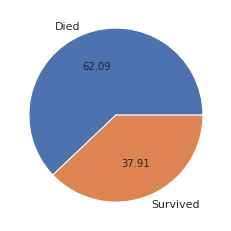

In [95]:
label_values = Y_train.value_counts()
display(label_values)
plt.pie(label_values, labels=['Died', 'Survived'], autopct='%.2f')
plt.show()

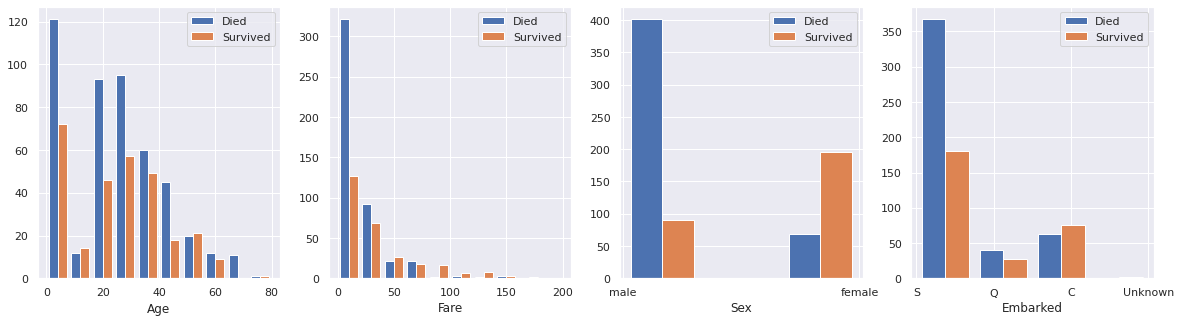

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1,4,1)
plt.hist([X_train['Age'][Y_train==0],
          X_train['Age'][Y_train==1]],
         label=['Died', 'Survived'])
plt.legend()
plt.xlabel('Age')
plt.subplot(1,4,2)
plt.hist([X_train['Fare'][Y_train==0],
          X_train['Fare'][Y_train==1]],
         label=['Died', 'Survived'],
         range=(0, 200))
plt.xlabel('Fare')
plt.legend()
plt.subplot(1,4,3)
plt.hist([X_train['Sex'][Y_train==0],
          X_train['Sex'][Y_train==1]],
         label=['Died', 'Survived'],
         bins=3)
plt.legend()
plt.xlabel('Sex')
plt.subplot(1,4,4)
plt.hist([X_train['Embarked'][Y_train==0],
          X_train['Embarked'][Y_train==1]],
         label=['Died', 'Survived'],
         bins=4)
plt.legend()
plt.xlabel('Embarked')

plt.show()

In [85]:
def majority_baseline(x):
  return 0  # corresponds to 'died'

def rule_baseline(x):
  if x['Sex'] == 'female':
    return 1  # 'survived'
  else:
    return 0  # 'died'

In [86]:
Y_train_pred_majority_baseline = X_train.apply(majority_baseline, axis=1)
Y_train_pred_rule_baseline = X_train.apply(rule_baseline, axis=1)
Y_test_pred_majority_baseline = X_test.apply(majority_baseline, axis=1)
Y_test_pred_rule_baseline = X_test.apply(rule_baseline, axis=1)

print('Majority baseline train accuracy:', np.sum(Y_train_pred_majority_baseline == Y_train) / len(Y_train))
print('Majority baseline test accuracy:', np.sum(Y_test_pred_majority_baseline == Y_test) / len(Y_test))
print('Rule baseline train accuracy:', np.sum(Y_train_pred_rule_baseline == Y_train) / len(Y_train))
print('Rule baseline test accuracy:', np.sum(Y_test_pred_rule_baseline == Y_test) / len(Y_test))

Majority baseline train accuracy: 0.6208718626155878
Majority baseline test accuracy: 0.5895522388059702
Rule baseline train accuracy: 0.7886393659180978
Rule baseline test accuracy: 0.7761194029850746


In [ ]:
tf.keras.backend.clear_session()
age = np.array(X_train['Age'])[0:10]
print(age)

age_bins = [0.1, 10, 40]
age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
print(age_binned)

age_id = tf.keras.layers.IntegerLookup(vocabulary=np.arange(0, len(age_bins)+1),
                                       output_mode='one_hot')(age_binned)
print(age_id)

[64. 21.  0. 40. 44. 23. 28. 33.  0. 18.]
tf.Tensor([3 2 0 3 3 2 2 2 0 2], shape=(10,), dtype=int64)
tf.Tensor(
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]], shape=(10, 5), dtype=float32)


In [43]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
  fare = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Fare')
  sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')
  pclass = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Pclass')
  emb = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Embarked')
  sibsp = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='SibSp')
  parch = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Parch')

  age_bins = [0.1, 5, 10, 15, 20, 30, 40, 50, 60, 70]
  age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
  age_id = tf.keras.layers.IntegerLookup(
      vocabulary=np.arange(0, len(age_bins)+1),
      output_mode='one_hot')(age_binned)

  fare_bins = [0.1, 10, 20, 40, 80, 160, 500]
  fare_binned = tf.keras.layers.Discretization(bin_boundaries=fare_bins)(fare)
  fare_id = tf.keras.layers.IntegerLookup(
      vocabulary=np.arange(0, len(fare_bins)+1),
      output_mode='one_hot')(fare_binned)

  sex_id = tf.cast(tf.keras.layers.StringLookup(
      vocabulary=['male', 'female'])(sex), float)

  pclass_id = tf.cast(tf.keras.layers.IntegerLookup(
      vocabulary=[1, 2, 3])(pclass), float)

  emb_id = tf.cast(tf.keras.layers.StringLookup(
      vocabulary=['S', 'C', 'Q', 'Unknown'], num_oov_indices=0)(emb), float)
  
  sibsp_id = tf.cast(tf.keras.layers.IntegerLookup(
      vocabulary=[0.1, 1, 2, 3, 10])(sibsp), float)
  
  parch_id = tf.cast(tf.keras.layers.IntegerLookup(
      vocabulary=[0.1, 1, 2, 3, 10])(parch), float)

  features = tf.keras.layers.Concatenate()([age_id, fare_id, sex_id, pclass_id, emb_id, sibsp_id, parch_id])
  
  y = tf.keras.layers.Dense(units=8, activation='tanh')(features)
  y = tf.keras.layers.Dense(units=4, activation='tanh')(features)
  y = tf.keras.layers.Dense(units=1, activation='sigmoid')(y)

  model = tf.keras.Model(inputs=[age, fare, sex, pclass, emb, sibsp, parch],
                         outputs=y,
                         name='TitanicSurvival')
  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                metrics=['accuracy'])
  return model

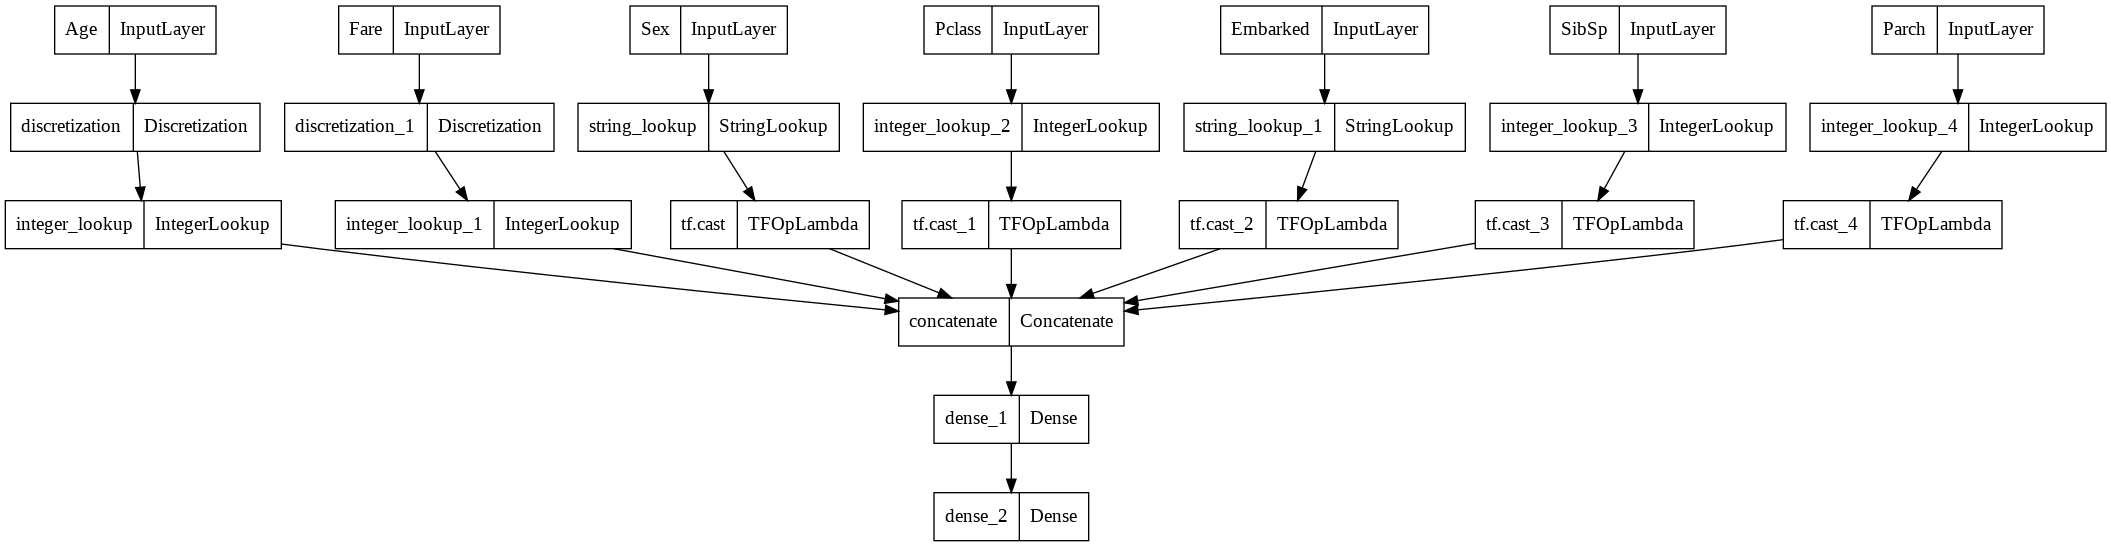

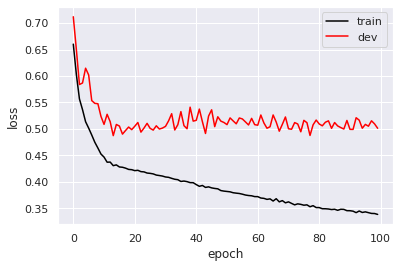

In [91]:
model = build_model()
#model.summary()
display(tf.keras.utils.plot_model(model))

history = model.fit(
  x = {
        'Age': X_train[['Age']],
        'Fare': X_train[['Fare']],
        'Sex': X_train[['Sex']],
        'Pclass': X_train[['Pclass']],
        'Embarked': X_train[['Embarked']],
        'SibSp': X_train[['SibSp']],
        'Parch': X_train[['Parch']],
      },
  y = Y_train,
  epochs=100,
  batch_size=256,
  validation_split=0.1,
  verbose=0,
  )

plt.plot(history.history['loss'], color='black', label='train')
plt.plot(history.history['val_loss'], color='red', label='dev')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [90]:
model.evaluate(
    x = {
        'Age': X_test[['Age']],
        'Fare': X_test[['Fare']],
        'Sex': X_test[['Sex']],
        'Pclass': X_test[['Pclass']],
        'Embarked': X_test[['Embarked']],
        'SibSp': X_test[['SibSp']],
        'Parch': X_test[['Parch']],
      },
    y=Y_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.3912 - accuracy: 0.8134


[0.3912089765071869, 0.8134328126907349]